In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, Lars
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Data Fields

- **datetime** - hourly date + timestamp  
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** 

    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 


- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals

##### Load Clean and Dummy-ize our variables

In [113]:
train = pd.read_csv('data/train.csv')
hold_out = pd.read_csv('data/test.csv')

def clean_frame(df):
    seasons = {'spring':1, 'summer':2, 'winter':3, 'fall':4}
    for season in seasons.iterkeys():
        df[season] = df['season'].isin([seasons[season]])

    weather_types = {'clear':1, 'mist':2, 'light':3, 'heavy':4}
    for weather in weather_types:
        df[weather] = df['weather'].isin([weather_types[weather]])

    ### drop stuff we don't need ###
    df = df.drop(['season', 'weather'], axis=1)
    df = df.set_index('datetime')

    ### Rearrange columns
    cols = df.columns
    cols = cols[6:9].append(cols[:6]).append(cols[9:])
    df = df[cols]
    df.index = pd.to_datetime(df.index)
    return df

train = clean_frame(train)

### Collinearity

Weather, humidity, temperature are collinear with the seasons, so any time series analysis would need to account for this effect. 

I suspect that weather's effect on whether people will use a bike are somewhat transient.  70 degrees feels like a great day for a bike ride, but if it's been 40 degrees for weeks, a 55 degree day may also feel similar.  

In [3]:
def pairplot(train, pair_variables, y_var):
    g = sns.pairplot(train[pair_variables],
                 kind='reg',
                 x_vars=pair_variables,
                y_vars=y_var,
                size=5)
    g.set(ylim=(0, 1500))


# Observations: Which Variables effect the outcome?

### Count against weather stats

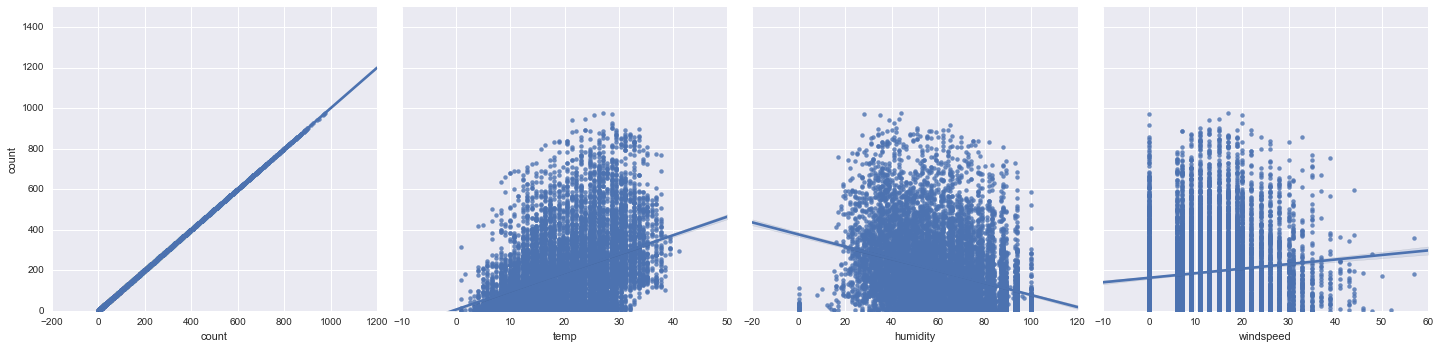

In [4]:
y = 'count'
pairplot(train, [y, 'temp', 'humidity', 'windspeed'], y_var=[y])

### Count against Weather Type

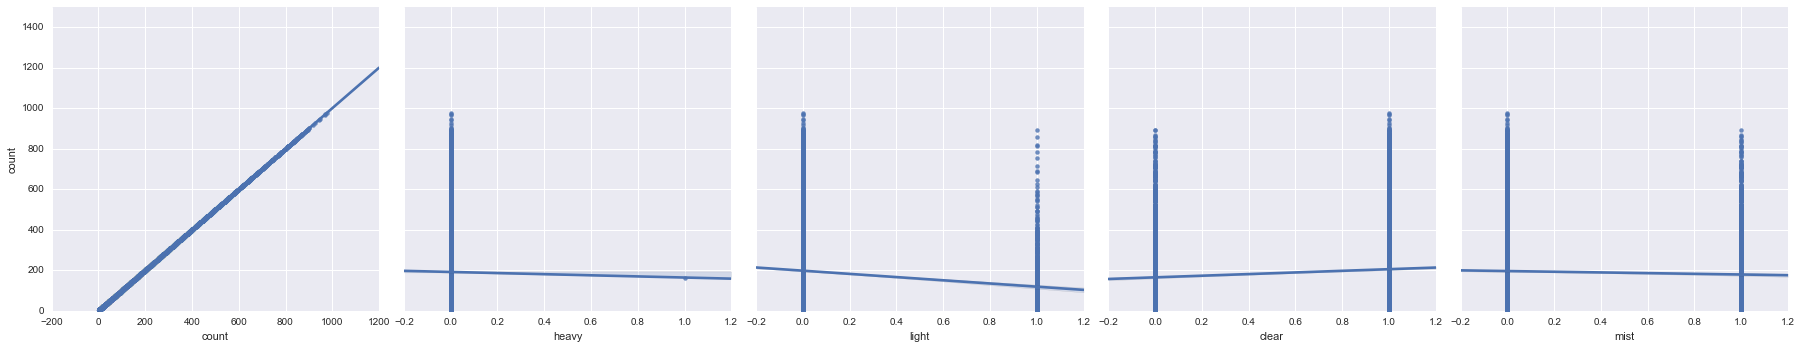

In [5]:
y = 'count'
pairplot(train, [y, 'heavy', 'light', 'clear', 'mist'], y_var=[y])

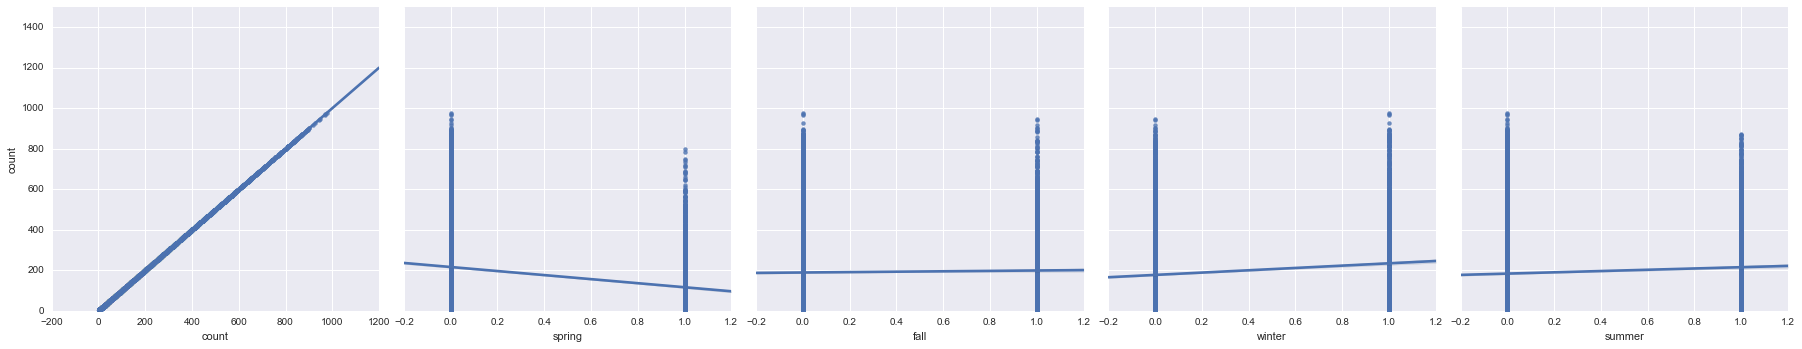

In [6]:
y = 'count'
pairplot(train, [y, 'spring', 'fall', 'winter', 'summer'], y_var=[y])

##### Let's look at how bike usage varies with time.  

In [8]:
train_wk_day = train[train['workingday'] == 1]
train_wknd = train[train['workingday'] == 0]

''

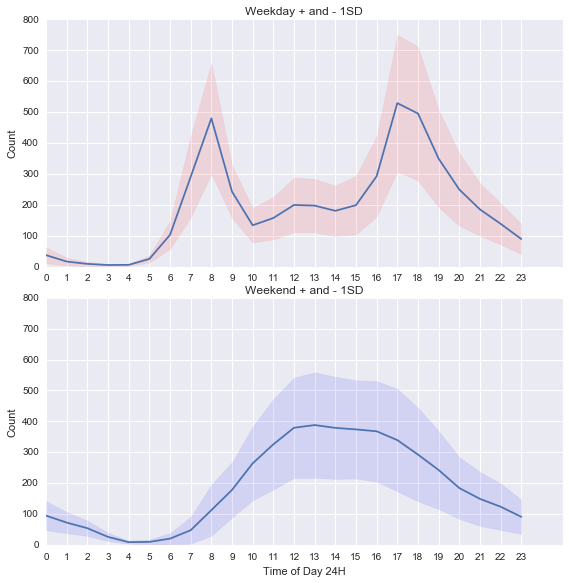

In [9]:
train_hours = train_wk_day.groupby(train_wk_day.index.hour)[['count', 'registered', 'casual']].mean()
std = train_wk_day.groupby(train_wk_day.index.hour)['count'].std()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 1, 1)
ax.plot(train_hours.drop(['registered', 'casual'], axis=1))

ax.fill_between(train_hours.index, train_hours['count'] - std,
                 train_hours['count'] + std, alpha=0.1, 
                                                    color="r")

plt.xticks(range(0, 24, 1))
plt.ylim(0, 800)
plt.title('Weekday + and - 1SD')
plt.ylabel('Count')

### Second Plot
train_wknd_hours = train_wknd.groupby(train_wknd.index.hour)[['count','registered','casual']].mean()
std_wknd = train_wknd.groupby(train_wknd.index.hour)['count'].std()

# train_wknd_hours.plot(xticks=range(0,23,1), ylim=(0, 600))
ax1 = fig.add_subplot(2, 1, 2)
ax1.plot(train_wknd_hours.drop(['registered', 'casual'], axis=1))
ax1.fill_between(train_wknd_hours.index, train_wknd_hours['count'] - std_wknd,
                 train_wknd_hours['count'] + std_wknd, alpha=0.1, 
                                                    color="b")


plt.xticks(range(0, 24, 1))
plt.ylim(0,800)
fig.tight_layout()
plt.xlabel('Time of Day 24H')
plt.title('Weekend + and - 1SD')
plt.ylabel('Count')
plt.savefig('/Users/ryanlambert/Desktop/bikes_per_hour.png')
;

In [ ]:
pd.ewma

# Observations

Based on what I have seen thus far I'm going to include hour of day as a dummy variable.  

There is a clear signal that is a function of what time of day it is.  

In [73]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_validation_curve(X, y, estimator, param_range=np.logspace(-6, 6, 4), param_name='ridge__alpha'):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name,
        param_range=param_range, cv=KFold(X.shape[0], n_folds=10, shuffle=True))
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)

    ax.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    ax.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    ax.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    ax.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    
    plt.title("Validation Curve Multiple Regression")
    plt.xlabel("Alpha")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)

    plt.legend(loc="best")
    plt.show()

def resid_plot(X, y, est):
    y_pred = est.predict(X)
    residuals = y - y_pred

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(y, residuals)
    plt.title('Residuals VS Fitted')

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.hist(residuals, orientation='horizontal')
    plt.title('Hist of Residuals')
    
def score_model(X, y, est):
    kf=KFold(X.shape[0], n_folds=10, shuffle=True)
    scores = cross_val_score(est, X, y, cv=kf)
    print("Cross Val Score: ", np.mean(scores))
    resid_plot(X, y, est)
    plot_learning_curve(est, 'Learning Curve', X, y, cv=kf);

# Make model without time first and see how good it is

In [114]:
y = train.iloc[:, 2]
X = train.drop(['casual', 'registered', 'count'], axis=1)

('Cross Val Score: ', 0.31251737532150559)


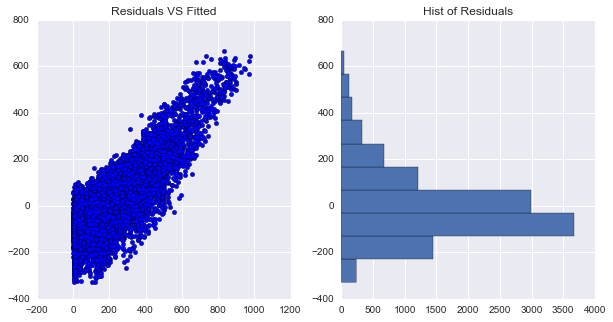

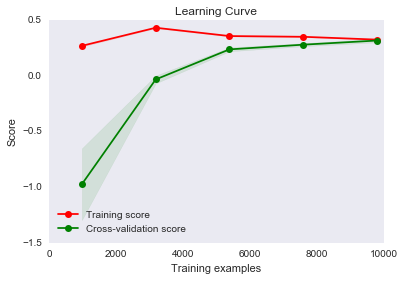

In [115]:
est = make_pipeline(PolynomialFeatures(2), Ridge())
est.fit(X, y)
score_model(X, y, est)

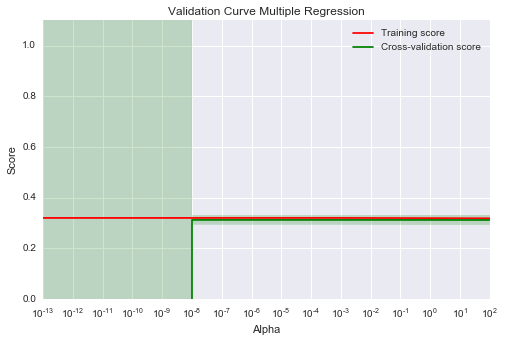

In [116]:
plot_validation_curve(X, y, est, param_range=np.logspace(-13, 2, 4))

##### This model doesn't appear to be putting regularization to any good use.  

('Cross Val Score: ', 0.27371344231845818)


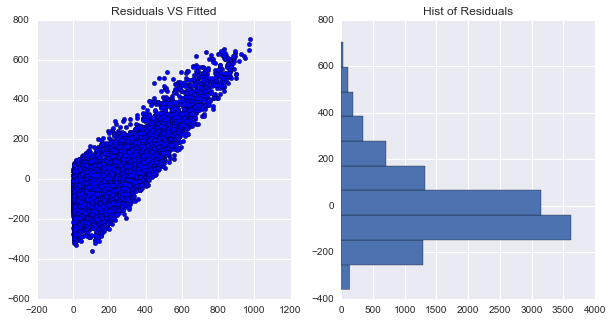

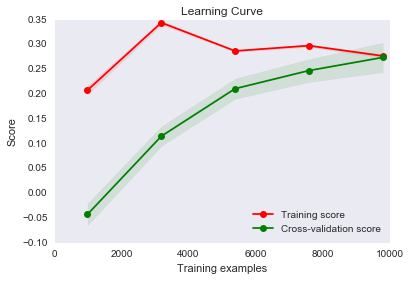

In [128]:
X1 = X
y1 = y
est3 = make_pipeline(PolynomialFeatures(1), Ridge())
est3.fit(X1, y1)
score_model(X1, y1, est3)

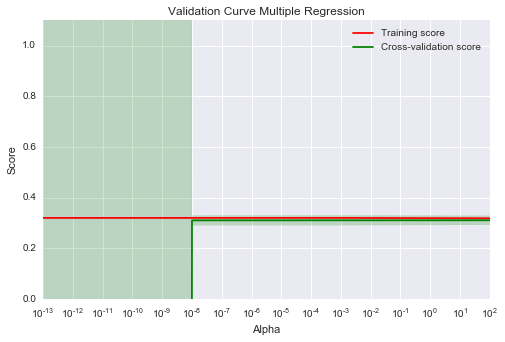

In [129]:
plot_validation_curve(X, y, est, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

##### Residuals are 'almost' normal, there's a bit more signal in there

### With hours as dummy variables

('Cross Val Score: ', 0.62976982120481895)


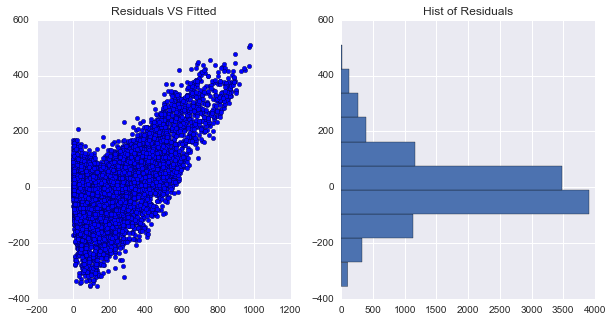

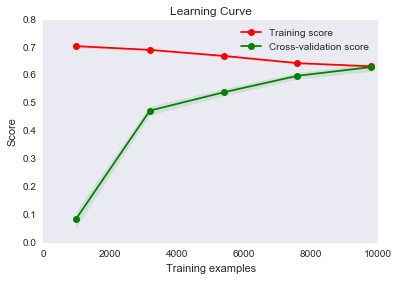

In [130]:
train_hrs = train.join(pd.get_dummies(train.index.hour, prefix='hr').set_index(train.index))
train_hrs.index = pd.to_datetime(train_hrs.index)
# train = train.join(pd.get_dummies(train.index.dayofweek, prefix='daywk').set_index(train.index))
# train.index = pd.to_datetime(train.index)
y2 = train_hrs.iloc[:, 2]
X2 = train_hrs.drop(['casual', 'registered', 'count'], axis=1)

est2 = make_pipeline(PolynomialFeatures(1), Ridge())
est2.fit(X2, y2)
score_model(X2, y2, est2)
# plot_validation_curve(X2, y2, est2, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

##### There's some improvement.  But maybe we can do better if we add some of our own features before we use Polynomials

('Cross Val Score: ', 0.6227973366350833)


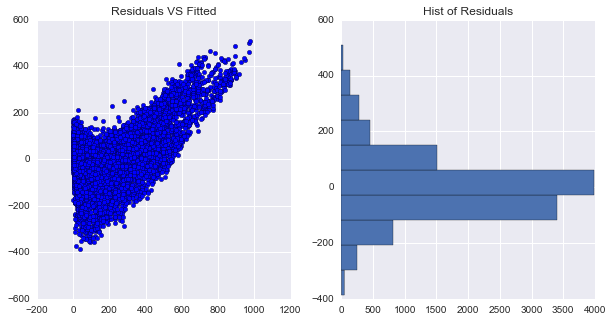

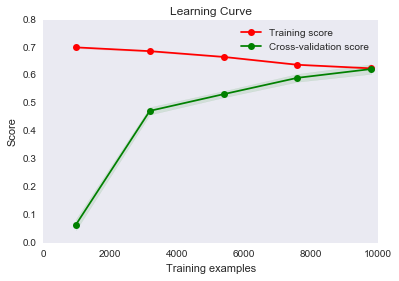

In [148]:
new_train = train_hrs.drop(['temp', 'humidity', 'windspeed'], axis=1)
y_dw = new_train.iloc[:, 2]
X_dw = new_train.drop(['casual', 'registered', 'count'], axis=1)

est_drop_wthr = make_pipeline(PolynomialFeatures(1), StandardScaler(), Ridge())
est_drop_wthr.fit(X_dw, y_dw)
score_model(X_dw, y_dw, est_drop_wthr)
# plot_validation_curve(X2, y2, est2, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

In [149]:
zip(X_dw.columns, est_drop_wthr.get_params()['ridge'].coef_)

[('holiday', 0.0),
 ('workingday', -0.90724041275247025),
 ('atemp', 1.2507526199517203),
 ('spring', 48.668272479837121),
 ('fall', -12.315280774305918),
 ('winter', 12.881696341002996),
 ('summer', -3.7896812637870454),
 ('heavy', 3.1504859969006072),
 ('light', -1.4462654233196894),
 ('clear', -18.421331673431219),
 ('mist', 9.5166149881634077),
 ('hr_0', 1.0806796715778089),
 ('hr_1', -26.187504842804167),
 ('hr_2', -29.528609478872234),
 ('hr_3', -31.612794774996697),
 ('hr_4', -33.396488970933916),
 ('hr_5', -34.001930711990347),
 ('hr_6', -31.165436808274645),
 ('hr_7', -19.432638247663213),
 ('hr_8', 7.7180252347041147),
 ('hr_9', 36.597483395809149),
 ('hr_10', 7.2061877983566793),
 ('hr_11', -3.2910341906364438),
 ('hr_12', 2.4461631944392095),
 ('hr_13', 10.820200905866312),
 ('hr_14', 10.099923269212432),
 ('hr_15', 6.8470156117490673),
 ('hr_16', 9.0649385449744226),
 ('hr_17', 21.579322717805763),
 ('hr_18', 53.036303636899838),
 ('hr_19', 46.091127573309727),
 ('hr_20', 

# With 2nd Order Poly

('Cross Val Score: ', 0.82423830868544079)


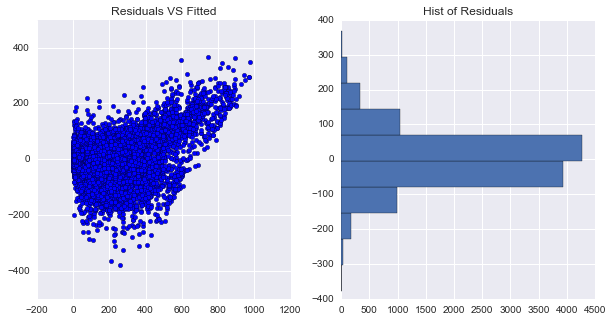

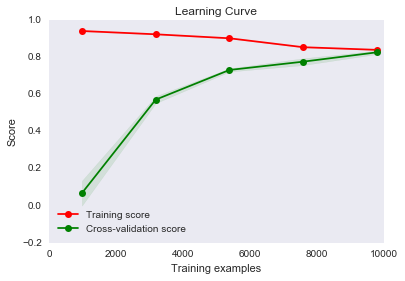

In [255]:
new_train = train_hrs
y_2nd = new_train.iloc[:, 2]
X_2nd = new_train.drop(['casual', 'registered', 'count'], axis=1)

est_2nd = make_pipeline(PolynomialFeatures(2), Ridge())
est_2nd.fit(X_2nd, y_2nd)
score_model(X_2nd, y_2nd, est_2nd)
# plot_validation_curve(X2, y2, est2, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

In [258]:
zip(X_2nd.columns, est_2nd.get_params()['ridge'].coef_)

[('holiday', 0.0),
 ('workingday', -30.608245353827709),
 ('temp', 2.2252575998557731),
 ('atemp', 13.54610253866108),
 ('humidity', -4.6267533413338677),
 ('windspeed', -0.04898482347993912),
 ('spring', 0.061811943528499988),
 ('fall', -41.24514198414586),
 ('winter', -4.4695251885389693),
 ('summer', 50.257958063723841),
 ('heavy', -4.5432908947220927),
 ('light', 0.0032772010794624071),
 ('clear', 16.491820240293983),
 ('mist', -12.961341111838607),
 ('hr_0', -3.5337563282783013),
 ('hr_1', -5.8956698908463547),
 ('hr_2', -10.727484144976522),
 ('hr_3', -13.269542043290921),
 ('hr_4', -25.932544251605687),
 ('hr_5', -31.743774921322949),
 ('hr_6', -26.334413440443473),
 ('hr_7', -35.727473859922775),
 ('hr_8', -59.633614931435105),
 ('hr_9', -39.91829748571989),
 ('hr_10', 2.2956028347837032),
 ('hr_11', 42.648396602166493),
 ('hr_12', 53.757877343913449),
 ('hr_13', 69.979486269457354),
 ('hr_14', 65.93002704514808),
 ('hr_15', 60.801451521708067),
 ('hr_16', 63.488198399900952),


# With hours X workday and hours X weekend

In [246]:
hr_dummies_wkdy = pd.get_dummies(train.index.hour, prefix='wkdy_hr').set_index(train.index)
hr_dummies_wknd = pd.get_dummies(train.index.hour, prefix='wknd_hr').set_index(train.index)
working_day_hrs = (train['workingday'] * hr_dummies_wkdy.T).T
weekend_day_hrs = ((train['workingday'] == 0) * hr_dummies_wknd.T).T
hrs_wkday_wkend = train.join(working_day_hrs)
hrs_wkday_wkend = hrs_wkday_wkend.join(weekend_day_hrs)
hrs_wkday_wkend.index = pd.to_datetime(hrs_wkday_wkend.index)
y4 = hrs_wkday_wkend.iloc[:, 2]
X4 = hrs_wkday_wkend.drop(['casual', 'registered', 'count', 'workingday', 'holiday'], axis=1)

('Cross Val Score: ', 0.76628830654049229)


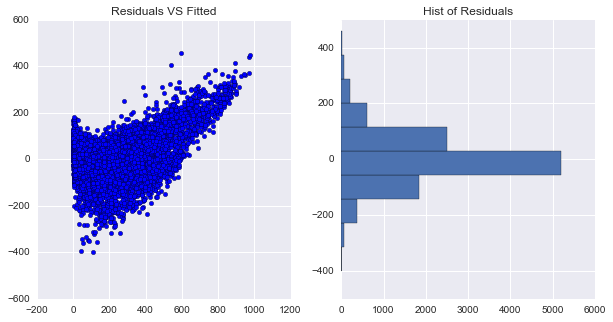

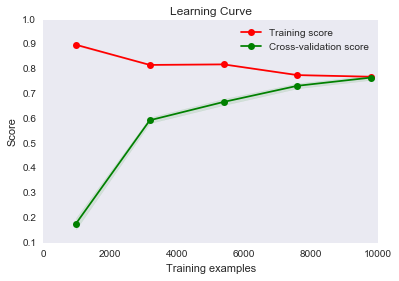

In [256]:
est4 = make_pipeline(PolynomialFeatures(1), Ridge())
est4.fit(X4, y4)
score_model(X4, y4, est4)
# plot_validation_curve(X2, y2, est2, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

In [251]:
zip(X4.columns, est4.get_params()['ridge'].coef_)

[('temp', 0.0),
 ('atemp', 4.9937107317161233),
 ('humidity', 1.430382029189543),
 ('windspeed', -0.99660965569537441),
 ('spring', -0.8800132271142127),
 ('fall', -30.267275040581406),
 ('winter', 34.851583006083956),
 ('summer', -11.382694591677838),
 ('heavy', 6.7983866247301137),
 ('light', -72.906116036298727),
 ('clear', -15.585423839288767),
 ('mist', 46.708380439377223),
 ('wkdy_hr_0', 41.783159437214245),
 ('wkdy_hr_1', -141.60201241076624),
 ('wkdy_hr_2', -157.33248083417121),
 ('wkdy_hr_3', -164.34111180252043),
 ('wkdy_hr_4', -167.80884625210098),
 ('wkdy_hr_5', -161.66113710506272),
 ('wkdy_hr_6', -138.97912742518147),
 ('wkdy_hr_7', -58.618103522073163),
 ('wkdy_hr_8', 125.38890863399631),
 ('wkdy_hr_9', 306.67744511386564),
 ('wkdy_hr_10', 60.329774798972593),
 ('wkdy_hr_11', -57.034132129836074),
 ('wkdy_hr_12', -45.713134243116116),
 ('wkdy_hr_13', -10.404400614390138),
 ('wkdy_hr_14', -20.188051032724296),
 ('wkdy_hr_15', -40.838089223497462),
 ('wkdy_hr_16', -23.7193

# Maybe let's do harmonic regression

In [155]:
ewma = pandas.stats.moments.ewma

# make a hat function, and add noise
x = np.linspace(0,1,100)
x = np.hstack((x,x[::-1]))
x += np.random.normal(loc=0, scale=0.1, size=200)
plot(x, alpha=0.4, label='Raw')

# take EWMA in both directions with a smaller span term
fwd = ewma( x, span=15 )          # take EWMA in fwd direction
bwd = ewma( x[::-1], span=15 )    # take EWMA in bwd direction
c = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
c = np.mean( c, axis=0 )          # average  

# regular EWMA, with bias against trend
plot( ewma( x, span=20 ), 'b', label='EWMA, span=20' )

# "corrected" (?) EWMA
plot( c, 'r', label='Reversed-Recombined' )

legend(loc=8)

# Maybe use maybe not

''

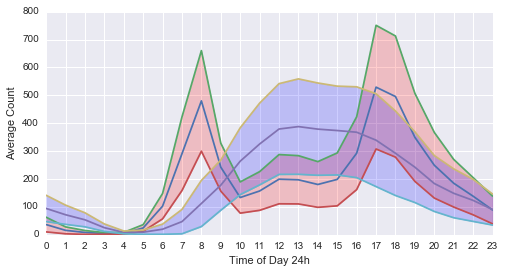

In [96]:
plt.figure(figsize=(8, 4))
plt.plot(train_hours.drop(['registered', 'casual', 'count_stdev'], axis=1))
plt.fill_between(train_hours.index, train_hours['count-stdev'],
                 train_hours['count+stdev'], alpha=0.1, 
                                                    color="r")
plt.fill_between(train_hours.index, train_hours['count-stdev'],
                 train_hours['count+stdev'], alpha=0.1, 
                                                    color="r")
plt.xticks(range(0, 24, 1))
plt.ylim(0, 800)

### Second Plot

plt.plot(train_wknd_hours.drop(['registered', 'casual', 'count_stdev'], axis=1))
plt.fill_between(train_wknd_hours.index, train_wknd_hours['count-stdev'],
                 train_wknd_hours['count+stdev'], alpha=0.1, 
                                                    color="b")
plt.fill_between(train_wknd_hours.index, train_wknd_hours['count-stdev'],
                 train_wknd_hours['count+stdev'], alpha=0.1, 
                                                    color="b")
plt.xticks(range(0, 24, 1))
plt.ylim(0,800)

plt.ylabel('Average Count')
plt.xlabel('Time of Day 24h')
;